
<div style="text-align: center; line-height: 0; padding-top: 9px;">
  <img src="https://databricks.com/wp-content/uploads/2018/03/db-academy-rgb-1200px.png" alt="Databricks Learning">
</div>



# LAB - Model Development Tracking with **MLflow**

In this lab, you will learn how to leverage MLflow to track and manage your model development process. First, you'll load data from a feature table and create train/test splits. Next, you'll train a classification model and track its training process using MLflow. Although MLflow supports autologging of metadata and artifacts, you will manually log parameters and artifacts to gain hands-on experience with its logging API.

📌 **Note:** In previous demos, we covered both supervised and unsupervised model training. In this lab, however, **you will focus exclusively on fitting and tracking a supervised model.**

**Lab Outline:**

- **Task 1:** Load the dataset from the feature store table.

- **Task 2:** Define the model hyperparameters.

- **Task 3:** Track the model using MLflow.

- **Task 4:** Log a custom figure.

- **Task 5:** Review the model details via the MLflow Experiment runs UI.



## REQUIRED - SELECT CLASSIC COMPUTE
Before executing cells in this notebook, please select your classic compute cluster in the lab. Be aware that **Serverless** is enabled by default.
Follow these steps to select the classic compute cluster:
1. Navigate to the top-right of this notebook and click the drop-down menu to select your cluster. By default, the notebook will use **Serverless**.
1. If your cluster is available, select it and continue to the next cell. If the cluster is not shown:
   - In the drop-down, select **More**.
   - In the **Attach to an existing compute resource** pop-up, select the first drop-down. You will see a unique cluster name in that drop-down. Please select that cluster.
  
**NOTE:** If your cluster has terminated, you might need to restart it in order to select it. To do this:
1. Right-click on **Compute** in the left navigation pane and select *Open in new tab*.
1. Find the triangle icon to the right of your compute cluster name and click it.
1. Wait a few minutes for the cluster to start.
1. Once the cluster is running, complete the steps above to select your cluster.

## Requirements

Please review the following requirements before starting the lesson:

* To run this notebook, you need to use one of the following Databricks runtime(s): **16.3.x-cpu-ml-scala2.12**


## Classroom Setup

Before starting the lab, run the provided classroom setup scripts. 

**📌 Note:** In this lab you will register MLflow models with Unity Catalog. Therefore, you will need to run the next code block to **set model registry URI to UC**. 


In [0]:
# %pip install --upgrade 'mlflow-skinny[databricks]'
dbutils.library.restartPython()

Next, this script will define configuration variables necessary for the demo. Execute the following cell:

In [0]:
%run ../Includes/Classroom-Setup-1.3

  Using cached databricks_sdk-0.36.0-py3-none-any.whl.metadata (38 kB)
Using cached databricks_sdk-0.36.0-py3-none-any.whl (569 kB)
  Attempting uninstall: databricks-sdk
    Found existing installation: databricks-sdk 0.30.0
    Not uninstalling databricks-sdk at /databricks/python3/lib/python3.12/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-48204b9d-f69f-494c-8297-ad8a6d6af12a
    Can't uninstall 'databricks-sdk'. No files were found to uninstall.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


2025/08/07 03:21:52 INFO databricks.ml_features._compute_client._compute_client: Setting columns ['customerID'] of table 'dbacademy.labuser11091541_1754532261.telco' to NOT NULL.
2025/08/07 03:21:54 INFO databricks.ml_features._compute_client._compute_client: Setting Primary Keys constraint ['customerID'] on table 'dbacademy.labuser11091541_1754532261.telco'.
2025/08/07 03:22:00 INFO databricks.ml_features._compute_client._compute_client: Created feature table 'dbacademy.labuser11091541_1754532261.telco'.


**Other Conventions:**

Throughout this demo, we'll refer to the object `DA`. This object, provided by Databricks Academy, contains variables such as your username, catalog name, schema name, working directory, and dataset locations. Run the code block below to view these details:

In [0]:
print(f"Username:          {DA.username}")
print(f"Catalog Name:      {DA.catalog_name}")
print(f"Schema Name:       {DA.schema_name}")
print(f"Working Directory: {DA.paths.working_dir}")
print(f"User DB Location:  {DA.paths.datasets}")

Username:          labuser11091541_1754532261@vocareum.com
Catalog Name:      dbacademy
Schema Name:       labuser11091541_1754532261
Working Directory: /Volumes/dbacademy/ops/labuser11091541_1754532261@vocareum_com
User DB Location:  NestedNamespace (california_housing='/Volumes/dbacademy_california_housing/v02', cdc_diabetes='/Volumes/dbacademy_cdc_diabetes/v01', telco='/Volumes/dbacademy_telco/v01', banking='/Volumes/dbacademy_banking/v01')


## Task 1 - Load Dataset from Feature Store Table

Use the feature store to load a dataset from a specific table.
   - **Load Dataset:** Utilize MLflow's `load_delta` function to seamlessly retrieve and load the dataset from the Feature Store table named **`"telco"`** in the specified catalog and schema `("DA.catalog_name" and "DA.schema_name")`. 
   - Convert dataset to `pandas` dataframe and explore the loaded dataset.

### Load Data

In [0]:
## Import the necessary library for MLflow
import mlflow

## Load the feature dataset using mlflow.data
feature_dataset = mlflow.data.load_delta(
    table_name=f"{DA.catalog_name}.{DA.schema_name}.telco",
    name="telco"
)
 
## convert the dataset to pandas df and drop the customerID column
feature_data_pd = feature_dataset.df.toPandas()
feature_data_pd = feature_data_pd.drop("customerID", axis=1)

## Convert all feature_data_pd columns to float
feature_data_pd = feature_data_pd.astype(float)

## inspect final dataset
display(feature_data_pd)

gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
1.0,0.0,1.0,0.0,0.0,1.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,997.0,2716.0,0.0
0.0,0.0,0.0,0.0,55.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,1438.0,1760.0,0.0
0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,614.0,508.0,1.0
0.0,0.0,0.0,0.0,65.0,1.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,2.0,1.0,2.0,1381.0,1696.0,0.0
1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,132.0,1242.0,1.0
1.0,0.0,0.0,0.0,8.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,158.0,6139.0,1.0
0.0,0.0,0.0,1.0,22.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,146.0,1826.0,0.0
1.0,0.0,0.0,0.0,12.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,780.0,2818.0,0.0
1.0,0.0,1.0,0.0,68.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,319.0,2855.0,1.0
0.0,0.0,0.0,1.0,46.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,252.0,3215.0,0.0


### Train / Test Split

Split the dataset into training and testing sets.

In [0]:
## Import necessary libraries
import mlflow.sklearn  # For MLflow integration
from sklearn.model_selection import train_test_split  # For splitting the dataset into training and testing sets

## Split the dataset into training and testing sets
target_col = "Churn"
X_all = feature_data_pd.drop(labels=target_col, axis=1)
y_all = feature_data_pd[target_col]
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=0.80, random_state=42)
print(f"We have {X_train.shape[0]} records in our training dataset")
print(f"We have {X_test.shape[0]} records in our test dataset")

We have 5634 records in our training dataset
We have 1409 records in our test dataset


## Task 2 - Define Model Hyperparameters

In this lab, you will train a classification model. In this task define parameters for a Decision Tree Model.

In [0]:
## Define Decision Tree Classifier parameters
dtc_params = {
  'criterion': 'gini',
  'max_depth': 50,
  'min_samples_split': 20,
  'min_samples_leaf': 5
}

##Task 3 - Track the Model Development  with MLflow

Initialize an MLflow run.
   - **Initialize MLflow Run:** Start an MLflow run to track the model development process. This allows for systematic recording of parameters, metrics, and artifacts associated with the model.

   - **Logging Model Details:** Utilize MLflow tracking to log essential information about the model, including parameters, metrics, and other relevant artifacts.

In [0]:
import mlflow
mlflow.set_registry_uri("databricks-uc")

In [0]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from mlflow.models.signature import infer_signature

## set the path for mlflow experiment
mlflow.set_experiment(f"/Users/{DA.username}/LAB-1-Model-Development-Tracking-with-MLflow")

## Turn off autologging as we want to log the model manually
mlflow.autolog(disable=True)

## Start an MLFlow run
with mlflow.start_run(run_name="Model Developing Tracking with MLflow Lab") as run:
   # Log the dataset
   mlflow.log_input(feature_dataset, context="source")
   mlflow.log_input(mlflow.data.from_pandas(X_train, source=feature_dataset.source), context="training")
   mlflow.log_input(mlflow.data.from_pandas(X_test, source=feature_dataset.source), context="test")

   ## Log parameters
   mlflow.log_params(dtc_params)

   ## Fit the model
   dtc = DecisionTreeClassifier(**dtc_params)
   dtc_mdl = dtc.fit(X_train, y_train)

   ## Define model signature
   signature = infer_signature(X_all, y_all)
    
   ## Log the model
   ## Define the model name based on the feature store catalog and schema
   model_name = f"{DA.catalog_name}.{DA.schema_name}.churnmodel"
   mlflow.sklearn.log_model(
       sk_model=dtc_mdl,
       artifact_path="model-artifacts",
       signature=signature,
       registered_model_name=model_name
   )

   ## Evaluate on the training set
   y_pred_train = dtc_mdl.predict(X_train)
   mlflow.log_metric("train_accuracy", accuracy_score(y_train, y_pred_train))
   mlflow.log_metric("train_precision", precision_score(y_train, y_pred_train))
   mlflow.log_metric("train_recall", recall_score(y_train, y_pred_train))
   mlflow.log_metric("train_f1", f1_score(y_train, y_pred_train))

   ## Evaluate on the test set
   y_pred_test = dtc_mdl.predict(X_test)
   mlflow.log_metric("test_accuracy", accuracy_score(y_test, y_pred_test))
   mlflow.log_metric("test_precision",  precision_score(y_test, y_pred_test))
   mlflow.log_metric("test_recall", recall_score(y_test, y_pred_test))
   mlflow.log_metric("test_f1", f1_score(y_test, y_pred_test))

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Registered model 'dbacademy.labuser11091541_1754532261.churnmodel' already exists. Creating a new version of this model...


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Created version '3' of model 'dbacademy.labuser11091541_1754532261.churnmodel'.
2025/08/07 03:43:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run Model Developing Tracking with MLflow Lab at: dbc-8b9f7bce-656b.cloud.databricks.com/ml/experiments/4297320214106129/runs/b65bb09a58224a6ca5bf9d343c175d72.
2025/08/07 03:43:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: dbc-8b9f7bce-656b.cloud.databricks.com/ml/experiments/4297320214106129.


## Task 4 - Log Custom Figure

**Log Custom Figure/Visualization:** Include the logging of a custom figure, such as a confusion matrix or any relevant visualization, to further illustrate the model's behavior. This visual representation can be valuable for model evaluation and interpretation.

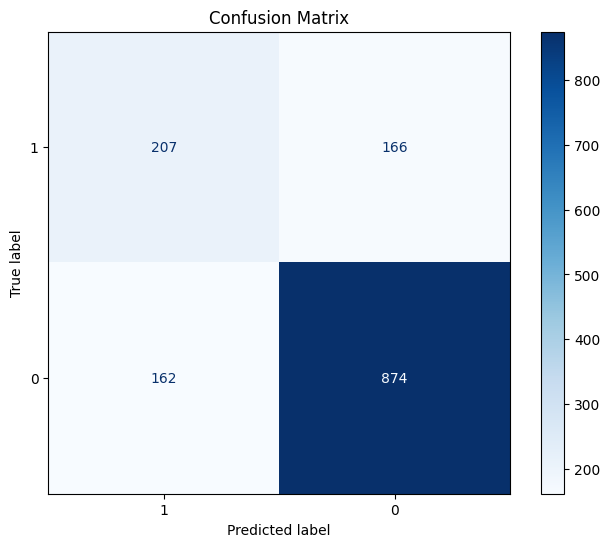

In [0]:
# TODO   
## Import necessary libraries for creating and displaying a confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from mlflow.client import MlflowClient
client = MlflowClient()

## Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_test, labels=[1, 0])

## Create a figure object and axes for the confusion matrix plot
fig, ax = plt.subplots(figsize=(8, 6))

## Create a ConfusionMatrixDisplay object with the computed confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])

## Plot the confusion matrix using the created axes and specified color map
disp.plot(cmap=plt.cm.Blues, ax=ax)

## Set the title of the plot
ax.set_title('Confusion Matrix')

## Log the confusion matrix figure to MLflow
client.log_figure(run.info.run_id, figure=fig, artifact_file="confusion_matrix.png")

## Task 5 - Review model details via the UI
To review the model details via the MLflow UI in the Experiment runs, follow these steps:

+ Step 1: Go to the "Experiments" Section

+ Step 2: Locate Your Experiment

+ Step 3: Review Run Details

+ Step 4: Reviewing Artifacts and Model metrics

+ Step 5: Viewing Confusion Matrix Image

+ Step 6: Retrieve Model Details


## Conclusion


In conclusion, this lab showcased the effectiveness of MLflow in seamlessly managing the model development process. Leveraging MLflow's features, such as experiment tracking, custom metric logging, and artifact storage, enhances collaboration and ensures reproducibility. The ability to review model details through the MLflow UI provides valuable insights into model performance and aids in making informed decisions.


&copy; 2025 Databricks, Inc. All rights reserved. Apache, Apache Spark, Spark, the Spark Logo, Apache Iceberg, Iceberg, and the Apache Iceberg logo are trademarks of the <a href="https://www.apache.org/" target="blank">Apache Software Foundation</a>.<br/>
<br/><a href="https://databricks.com/privacy-policy" target="blank">Privacy Policy</a> | 
<a href="https://databricks.com/terms-of-use" target="blank">Terms of Use</a> | 
<a href="https://help.databricks.com/" target="blank">Support</a>